In [1]:
import os
import torch
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from PIL import Image
from diffusers import AutoencoderKL

In [2]:
# Helper function to load images from a given subdirectory (expects frame1.jpg, frame2.jpg, frame3.jpg)
def load_frames(subdir):
    frames = []
    for i in range(1, 4):
        path = os.path.join(subdir, f"frame{i}.jpg")
        if os.path.exists(path):
            frames.append(Image.open(path).convert("RGB"))
    return frames

# Function to encode and decode images using the VAE.
def encode_decode_images(vae, images, transform, device):
    vae.eval()
    reconstructed = []
    for img in images:
        inp = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            # For diffusers AutoencoderKL, we typically do:
            posterior = vae.encode(inp).latent_dist
            z = posterior.sample()
            recon = vae.decode(z).sample.cpu()[0]
        # Denormalize assuming [-1,1] normalized with mean=0.5 and std=0.5
        recon_img = transforms.ToPILImage()( (recon * 0.5 + 0.5).clamp(0,1) )
        reconstructed.append(recon_img)
    return reconstructed

In [3]:
# Set device (adjust as needed)
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [13]:
# Load the trained VAE and checkpoint (adjust if using your custom model)
vae = AutoencoderKL.from_pretrained("bullhug/kl-f8-anime2")
# vae.load_state_dict(torch.load("/code/ggonsior/487/latent-interp/vae/checkpoints/vae_r2_epoch10.pth", map_location=device))
vae.to(device)

An error occurred while trying to fetch bullhug/kl-f8-anime2: bullhug/kl-f8-anime2 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

In [14]:

# Define transform – must match what was used for training.
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

# Define base directories for splits
splits = ["train", "val", "test"]
# For each split, we pick one subdir that contains "Disney" and one that contains "Japan"
base_dir = "/data/ggonsior/atd12k"

In [15]:
def pick_subdirs(split):
    split_dir = os.path.join(base_dir, split)
    disney = None
    japan = None
    for subdir in os.listdir(split_dir):
        if "Disney" in subdir and disney is None:
            disney = os.path.join(split_dir, subdir)
        if "Japan" in subdir and japan is None:
            japan = os.path.join(split_dir, subdir)
        if disney and japan:
            break
    return disney, japan

Split: train


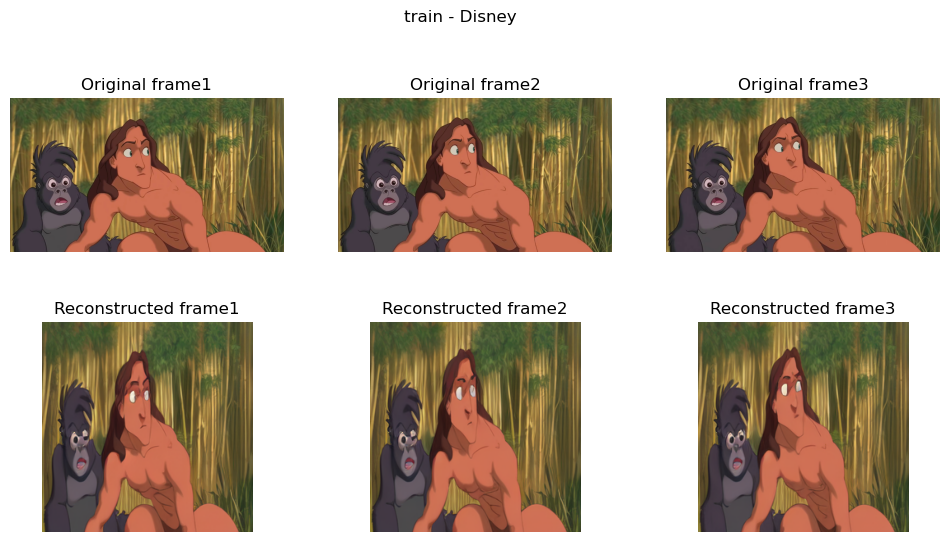

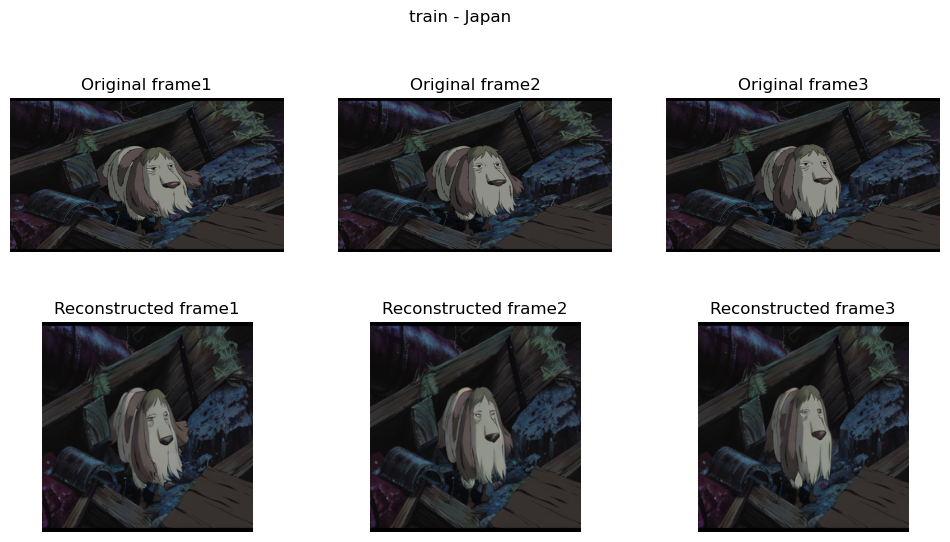

Split: val


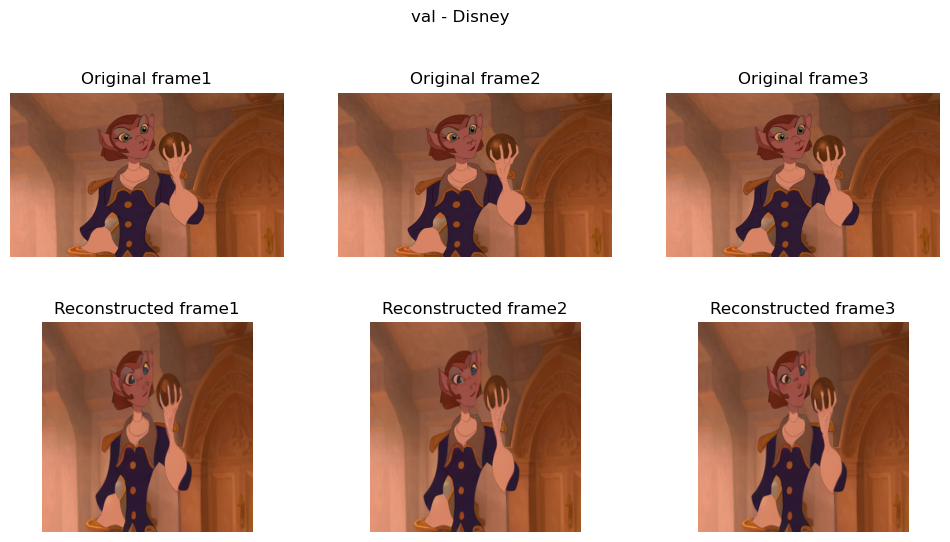

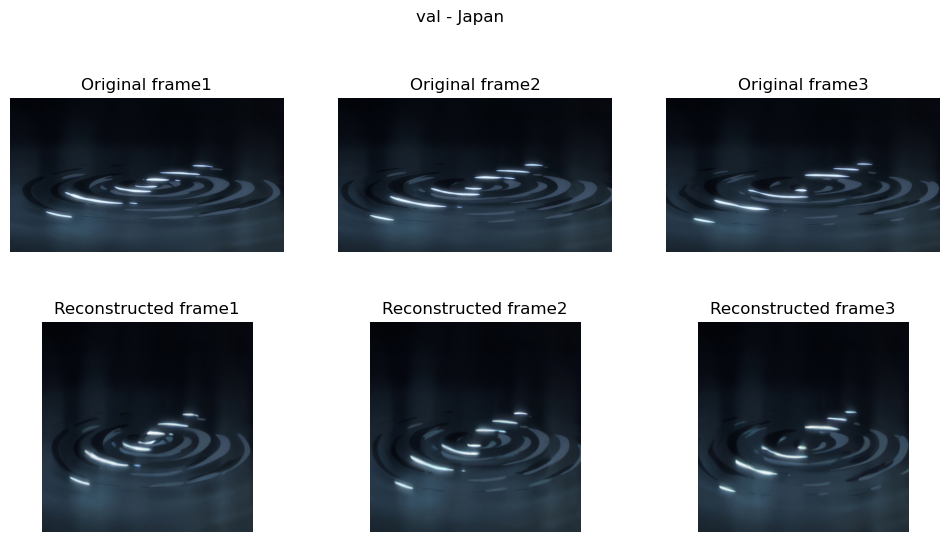

Split: test


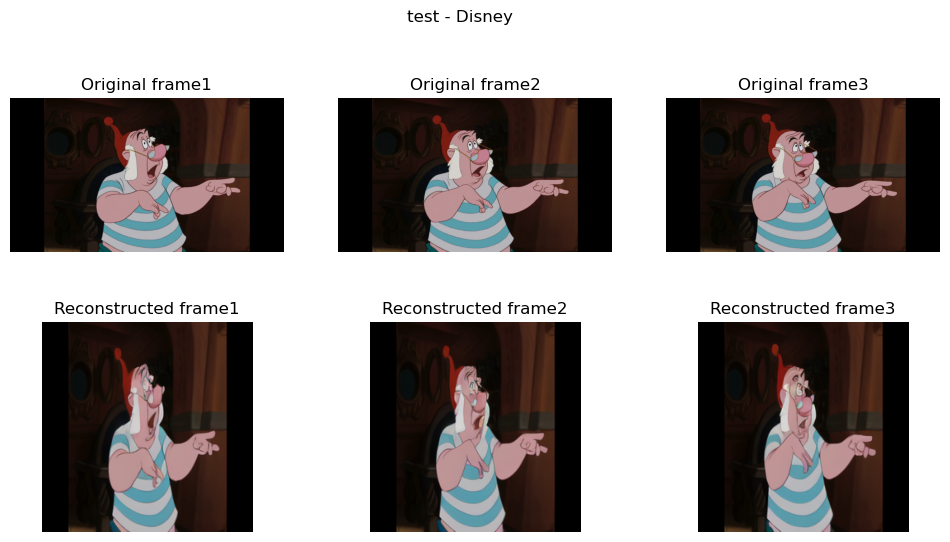

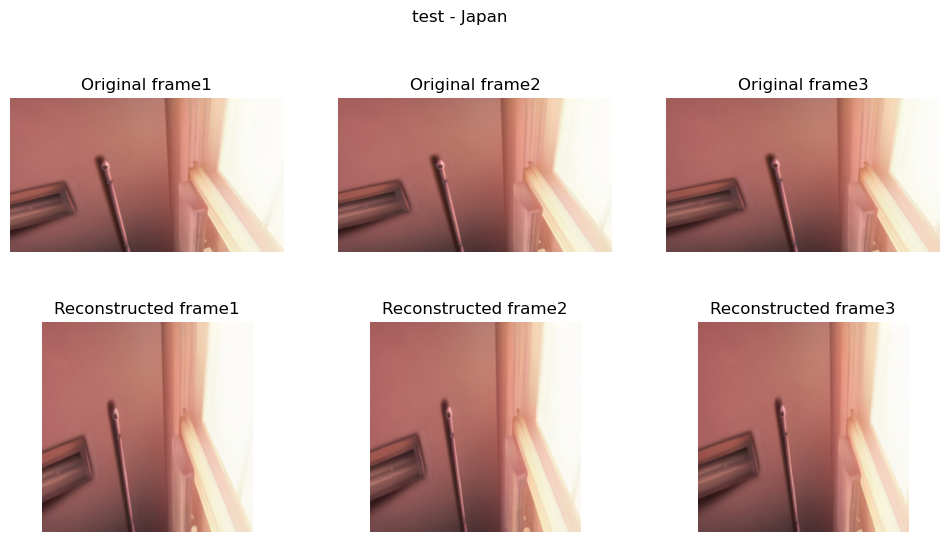

In [16]:
# Loop over splits and display visual comparisons
for split in splits:
    disney_subdir, japan_subdir = pick_subdirs(split)
    print(f"Split: {split}")
    for label, subdir in [("Disney", disney_subdir), ("Japan", japan_subdir)]:
        frames = load_frames(subdir)
        recon_frames = encode_decode_images(vae, frames, transform, device)
        
        fig, axes = plt.subplots(2, 3, figsize=(12,6))
        for i in range(3):
            axes[0,i].imshow(frames[i])
            axes[0,i].axis("off")
            axes[0,i].set_title(f"Original frame{i+1}")
            axes[1,i].imshow(recon_frames[i])
            axes[1,i].axis("off")
            axes[1,i].set_title(f"Reconstructed frame{i+1}")
        plt.suptitle(f"{split} - {label}")
        plt.show()